In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
import random

import torch
import torch.utils.data as data
from PIL import Image
from torchvision import transforms

import torch.nn as nn
import torchvision.models as models
import torch.optim as optim

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.11) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1,2,3"  
torch.cuda.device_count()

3

In [3]:
os.makedirs("flickr8", exist_ok=True)
os.chdir("flickr8")

In [4]:
# !wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
# !wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip
# !unzip -qq Flickr8k_Dataset.zip
# !unzip -qq Flickr8k_text.zip
# !rm Flickr8k_Dataset.zip Flickr8k_text.zip

In [5]:
!ls -lh

total 1.1G
-rw-r--r-- 1 qblocks qblocks 2.8M Oct 14  2013 CrowdFlowerAnnotations.txt
-rw-r--r-- 1 qblocks qblocks 339K Oct 14  2013 ExpertAnnotations.txt
drwxr-xr-x 1 qblocks qblocks 392K Oct  3  2012 Flicker8k_Dataset
-rw-r--r-- 1 qblocks qblocks 3.1M Feb 16  2012 Flickr8k.lemma.token.txt
-rw-r--r-- 1 qblocks qblocks 3.3M Oct 14  2013 Flickr8k.token.txt
-rw-r--r-- 1 qblocks qblocks 1.1G Dec  6  2021 Flickr8k_Dataset.zip
-rw-r--r-- 1 qblocks qblocks 2.3M Dec  6  2021 Flickr8k_text.zip
-rw-r--r-- 1 qblocks qblocks  26K Oct 10  2013 Flickr_8k.devImages.txt
-rw-r--r-- 1 qblocks qblocks  26K Oct 10  2013 Flickr_8k.testImages.txt
-rw-r--r-- 1 qblocks qblocks 152K Oct 10  2013 Flickr_8k.trainImages.txt
drwxrwxr-x 1 qblocks qblocks  124 Jul 15 14:49 __MACOSX
drwxr-xr-x 1 qblocks qblocks   86 Jul 17 20:05 checkpoint
drwxr-xr-x 1 qblocks qblocks  678 Jul 17 19:02 logs
-rw-r--r-- 1 qblocks qblocks 1.8K Oct 14  2013 readme.txt
drwxr-xr-x 1 qblocks qblocks    0 Jul 17 18:35 results


In [6]:
!cat readme.txt

If you use this corpus / data:

Please cite: M. Hodosh, P. Young and J. Hockenmaier (2013) "Framing Image Description as a Ranking Task: Data, Models and Evaluation Metrics", Journal of Artifical Intellegence Research, Volume 47, pages 853-899
http://www.jair.org/papers/paper3994.html


Captions, Dataset Splits, and Human Annotations :


Flickr8k.token.txt - the raw captions of the Flickr8k Dataset . The first column is the ID of the caption which is "image address # caption number"

Flickr8k.lemma.txt - the lemmatized version of the above captions 

Flickr_8k.trainImages.txt - The training images used in our experiments
Flickr_8k.devImages.txt - The development/validation images used in our experiments
Flickr_8k.testImages.txt - The test images used in our experiments


ExpertAnnotations.txt is the expert judgments.  The first two columns are the image and caption IDs.  Caption IDs are <image file name>#<0-4>.  The next three columns are the expert judgments for that image-caption pai

In [7]:
df = pd.read_csv("Flickr8k.token.txt", sep="\t", header=None)
df.columns = ["image", "caption"]
df['num'] = df.apply(lambda row: row['image'].split("#")[-1], axis=1)
df['image'] = df['image'].apply(lambda x: x.split("#")[0])
df

,image,caption,num
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...,0
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,1
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .,2
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...,3
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...,4
...,...,...,...
40455,997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face,0
40456,997722733_0cb5439472.jpg,A man is rock climbing high in the air .,1
40457,997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock fac...,2
40458,997722733_0cb5439472.jpg,A rock climber in a red shirt .,3


In [8]:
train_images, validation_images, test_images = [], [], []

with open("Flickr_8k.trainImages.txt", "r") as f:
    for line in f:
        train_images.append(line.strip())

with open("Flickr_8k.devImages.txt", "r") as f:
    for line in f:
        validation_images.append(line.strip())

with open("Flickr_8k.testImages.txt", "r") as f:
    for line in f:
        test_images.append(line.strip())

len(train_images), len(validation_images), len(test_images)

(6000, 1000, 1000)

In [9]:
# train_images = train_images[:100]
# validation_images = validation_images[:20]
# test_images = test_images[:20]

In [10]:
img2idx = {img: idx + 1 for idx, img in enumerate(train_images + validation_images + test_images)}
img2idx["<PAD>"] = 0

In [11]:
!ls Flicker8k_Dataset | head

1000268201_693b08cb0e.jpg
1001773457_577c3a7d70.jpg
1002674143_1b742ab4b8.jpg
1003163366_44323f5815.jpg
1007129816_e794419615.jpg
1007320043_627395c3d8.jpg
1009434119_febe49276a.jpg
1012212859_01547e3f17.jpg
1015118661_980735411b.jpg
1015584366_dfcec3c85a.jpg
ls: write error: Broken pipe


In [12]:
def show_image(image, title=None):
    image[0] = image[0] * 0.229
    image[1] = image[1] * 0.224
    image[2] = image[2] * 0.225
    image[0] += 0.485
    image[1] += 0.456
    image[2] += 0.406

    image = image.numpy().transpose((1, 2, 0))


    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

In [13]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
])

# **Encoder**

In [14]:
class EncoderCNN(nn.Module):
    def __init__(self):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False) # upto you if you want to make this True or False

        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        
    def forward(self, images):
        features = self.resnet(images)
        features = features.view(features.size(0), -1)
        return features

In [15]:
device = torch.device("cuda")
encoder = EncoderCNN().to(device)

/home/qblocks/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/qblocks/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# **Decoder**

In [16]:
from datasets import load_dataset

import torch
import time
import evaluate
import pandas as pd
import numpy as np

2023-07-17 20:10:15.595664: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-17 20:10:16.983027: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/qblocks/.local/lib/python3.8/site-packages/cv2/../../lib64:
2023-07-17 20:10:16.983158: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/qblocks/.local/lib/python3.8/site-packages/cv2/../../lib64

In [17]:
import transformers
import textwrap
from transformers import LlamaTokenizer, LlamaForCausalLM
import os
import sys
from typing import List
 
from peft import (
    LoraConfig,
    get_peft_model,
    get_peft_model_state_dict,
    prepare_model_for_int8_training,
)
 
import fire
import torch
from datasets import load_dataset
import pandas as pd
 
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from pylab import rcParams


BASE_MODEL = "decapoda-research/llama-7b-hf"
 
model = LlamaForCausalLM.from_pretrained(
    BASE_MODEL,
    load_in_8bit=True,
    torch_dtype=torch.float16,
    device_map="auto",
)
 
tokenizer = LlamaTokenizer.from_pretrained(BASE_MODEL)
 
tokenizer.pad_token_id = (
    0  # unk. we want this to be different from the eos token
)
tokenizer.padding_side = "right"


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please submit your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
CUDA_SETUP: WARNING! libcudart.so not found in any environmental path. Searching /usr/local/cuda/lib64...
CUDA SETUP: CUDA runtime path found: /usr/local/cuda/lib64/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 8.6
CUDA SETUP: Detected CUDA version 113
CUDA SETUP: Loading binary /home/qblocks/.local/lib/python3.8/site-packages/bitsandbytes/libbitsandbytes_cuda113.so...


/home/qblocks/.local/lib/python3.8/site-packages/bitsandbytes/cuda_setup/main.py:136: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('/home/qblocks/.local/lib/python3.8/site-packages/cv2/../../lib64')}
  warn(msg)
/home/qblocks/.local/lib/python3.8/site-packages/bitsandbytes/cuda_setup/main.py:136: UserWarning: /home/qblocks/.local/lib/python3.8/site-packages/cv2/../../lib64: did not contain libcudart.so as expected! Searching further paths...
  warn(msg)
/home/qblocks/.local/lib/python3.8/site-packages/bitsandbytes/cuda_setup/main.py:136: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('module'), PosixPath('//matplotlib_inline.backend_inline')}
  warn(msg)


Loading checkpoint shards:   0%|          | 0/33 [00:00<?, ?it/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'LLaMATokenizer'. 
The class this function is called from is 'LlamaTokenizer'.


In [18]:
model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096, padding_idx=31999)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear8bitLt(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear8bitLt(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear8bitLt(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear8bitLt(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear8bitLt(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear8bitLt(in_features=11008, out_features=4096, bias=False)
          (up_proj): Linear8bitLt(in_features=4096, out_features=11008, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): Llama

In [19]:
from tqdm import tqdm


class Flickr8kDataset(data.Dataset):
    def __init__(self, image_dir, image_names, transform=None):
        self.image_dir = image_dir
        self.image_ids = image_names
        self.transform = transform

    def __getitem__(self, index):
        image_id = self.image_ids[index]
        image_file = f'{self.image_dir}/{image_id}'
        image = Image.open(image_file).convert('RGB')
        image = image.resize((512, 512))

        if self.transform:
            image = self.transform(image)

        return image, image_id

    def __len__(self):
        return len(self.image_ids)

    
dataset = Flickr8kDataset("Flicker8k_Dataset", list(img2idx.keys())[:-1], transform=transform)
dataloader = data.DataLoader(dataset, batch_size=128, shuffle=False)

encoder.eval()
img_emb = [torch.zeros((1, 2048))]

with torch.no_grad():
    for images, name in tqdm(dataloader):
        images = images.to(device)

        out = encoder(images)
        img_emb.append(out.cpu())

img_emb = torch.cat(img_emb)


# change Llama Embedding
class CustomEmbedding(nn.Module):
    def __init__(self):
        super(CustomEmbedding, self).__init__()
        self.llama_emb = nn.Embedding(32000, 4096)
        self.llama_emb.weight.data.copy_(model.model.embed_tokens.weight.data)

        self.img_emb = nn.Embedding.from_pretrained(img_emb, freeze=True)
        self.fc_enc = nn.Linear(2048, 4096) # resnet.fc.in_features = 2048
        
    def forward(self, x):
        """
        x - [batch, seq_len]
        """
        llama = self.llama_emb(x[:, 1:])
        img = self.fc_enc(self.img_emb(x[:, :1]))
        
        return torch.cat([img, llama], dim=1)
    
model.model.embed_tokens = CustomEmbedding().to(device)

100%|██████████| 63/63 [01:54<00:00,  1.82s/it]


In [20]:
model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): CustomEmbedding(
      (llama_emb): Embedding(32000, 4096)
      (img_emb): Embedding(8001, 2048)
      (fc_enc): Linear(in_features=2048, out_features=4096, bias=True)
    )
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear8bitLt(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear8bitLt(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear8bitLt(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear8bitLt(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear8bitLt(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear8bitLt(in_features=11008, out_features=4096, bias=False)
          (up_proj): Linear8bitLt(in_features=4096, out_features=11008, bias=Fals

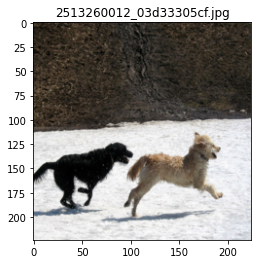

In [21]:
image, caption = dataset[0]
show_image(image, caption)

In [22]:
image, caption = dataset[0]
encoder(image[None, :].to(device)).shape

torch.Size([1, 2048])

# Prepare Dataset

In [23]:
from datasets import Dataset
from datasets import DatasetDict

dataset = lambda images, split: Dataset.from_pandas(pd.DataFrame(images, columns=["image"]).merge(df.drop("num", axis=1), how="inner"), preserve_index=False, split=split)

train_dataset = dataset(train_images, "train")
val_dataset = dataset(validation_images, "validation")
test_dataset = dataset(test_images, "test")

train_dataset, val_dataset, test_dataset

(Dataset({
     features: ['image', 'caption'],
     num_rows: 30000
 }),
 Dataset({
     features: ['image', 'caption'],
     num_rows: 5000
 }),
 Dataset({
     features: ['image', 'caption'],
     num_rows: 5000
 }))

In [24]:
full_dataset = DatasetDict()

full_dataset["train"] = train_dataset
full_dataset["validation"] = val_dataset
full_dataset["test"] = test_dataset

full_dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'caption'],
        num_rows: 30000
    })
    validation: Dataset({
        features: ['image', 'caption'],
        num_rows: 5000
    })
    test: Dataset({
        features: ['image', 'caption'],
        num_rows: 5000
    })
})

# Tokenize

In [25]:
CUTOFF_LEN = 50

prompt = "Write a caption for the image. \nCaption: \n"


def tokenize(datapoint, add_eos_token=True):
    caption = datapoint["caption"]
    image_name = datapoint["image"]
    
    tokens = tokenizer(
        prompt + caption,
        truncation=True,
        padding="max_length",
        return_tensors="pt",
        max_length=50
        
    )
    tokens["input_ids"][0, 0] = img2idx[image_name]
    
    tokens["input_ids"] = tokens["input_ids"].squeeze(0)
    tokens["attention_mask"] = tokens["attention_mask"].squeeze(0)
 
    tokens["labels"] = tokens["input_ids"].clone()
    return tokens

tokenize(train_dataset[0], True)

{'input_ids': tensor([    1, 14350,   263,  5777,   683,   363,   278,  1967, 29889, 29871,
           13, 26270,   683, 29901, 29871,    13, 29909,  4628, 11203,   338,
         2734,  1156,   263,  4796, 11203,   297,   278, 15007,   869,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0]), 'labels': tensor([    1, 14350,   263,  5777,   683,   363,   278,  1967, 29889, 29871,
           13, 26270,   683, 29901, 29871,    13, 29909,  4628, 11203,   338,
         2734,  1156,   263,  4796, 11203,   297,   278, 15007,   869,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])

In [26]:
train_dataset[0]

{'image': '2513260012_03d33305cf.jpg',
 'caption': 'A black dog is running after a white dog in the snow .'}

In [27]:
train_data = (
    full_dataset["train"].map(tokenize)
)

test_data = (
    full_dataset["test"].map(tokenize)
)

Map:   0%|          | 0/30000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

In [28]:
train_data = train_data.remove_columns(['image', 'caption'])
test_data = test_data.remove_columns(['image', 'caption'])

In [ ]:
LORA_R = 8
LORA_ALPHA = 16
LORA_DROPOUT= 0.05
LORA_TARGET_MODULES = [
    "q_proj",
    "v_proj",
    "fc_enc"
]
 
BATCH_SIZE = 256
MICRO_BATCH_SIZE = 4
GRADIENT_ACCUMULATION_STEPS = BATCH_SIZE // MICRO_BATCH_SIZE
LEARNING_RATE = 3e-4
TRAIN_STEPS = 600
OUTPUT_DIR = "./checkpoint" # "experiments"


# prepare lora model
model = prepare_model_for_int8_training(model)
config = LoraConfig(
    r=LORA_R,
    lora_alpha=LORA_ALPHA,
    target_modules=LORA_TARGET_MODULES,
    lora_dropout=LORA_DROPOUT,
    bias="none",
    task_type="CAUSAL_LM",
)
model = get_peft_model(model, config)
model.print_trainable_parameters()


# set training arguments
training_arguments = transformers.TrainingArguments(
    per_device_train_batch_size=MICRO_BATCH_SIZE,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
    warmup_steps=100,
    # num_train_epochs=20,
    max_steps=TRAIN_STEPS,
    learning_rate=LEARNING_RATE,
    fp16=True,
    logging_steps=5,
    optim="adamw_torch",
    evaluation_strategy="steps",
    save_strategy="steps",
    eval_steps=5, # 50
    save_steps=5, # 50
    output_dir=OUTPUT_DIR,
    save_total_limit=3,
    load_best_model_at_end=True,
    report_to="tensorboard"
)

data_collator = transformers.DataCollatorForSeq2Seq(
    tokenizer, pad_to_multiple_of=8, return_tensors="pt", padding=True
)

# set trainer
trainer = transformers.Trainer(
    model=model,
    train_dataset=train_data,
    eval_dataset=test_data,
    args=training_arguments,
    data_collator=data_collator
)

model.config.use_cache = False

old_state_dict = model.state_dict

model.state_dict = (
    lambda self, *_, **__: get_peft_model_state_dict(
        self, old_state_dict()
    )
).__get__(model, type(model))
 
model = torch.compile(model)
 
trainer.train()
model.save_pretrained(OUTPUT_DIR)

trainable params: 4243456 || all params: 6767437824 || trainable%: 0.06270402640347923
